In [47]:
import pandas as pd
import numpy as np

from news_vec.corpus import Corpus

from tqdm import tqdm
from boltons.iterutils import windowed
from collections import Counter
from itertools import combinations

from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [61]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [2]:
corpus = Corpus('../data/clf-links.json/', '../data/clf-headlines.json/')

2018-12-26 01:13:54,110 | INFO : Reading links.
1225511it [00:03, 369991.04it/s]
2018-12-26 01:13:59,325 | INFO : Reading headlines.
1127502it [00:20, 53855.03it/s]


In [33]:
ds = corpus.sample_a_vs_b('breitbart.com', 'rt.com')

In [34]:
df = ds.to_df()

In [54]:
def a_vs_b(a, b, verbose=True):
    
    ds = corpus.sample_a_vs_b(a, b)
    df = ds.to_df()
    
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )
    
    clf = LinearSVC()
    
    X = tv.fit_transform(df.tokens)
    
    return cross_val_score(clf, X, df.domain, cv=10, n_jobs=-1, verbose=verbose)

In [55]:
a_vs_b('nytimes.com', 'npr.org')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    4.6s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.1s finished


array([0.68739294, 0.68773553, 0.69749914, 0.68670778, 0.68979102,
       0.70253598, 0.69379712, 0.68934202, 0.69276902, 0.68317341])

In [56]:
domains = corpus.unique_articles.domain.unique()

In [57]:
pairs = list(combinations(domains, 2))

In [58]:
rows = []
for a, b in tqdm(pairs):
    scores = a_vs_b(a, b, False)
    for s in scores:
        rows.append((a, b, s))

100%|██████████| 120/120 [22:53<00:00, 11.46s/it]


In [59]:
score_df = pd.DataFrame(rows, columns=('d1', 'd2', 'acc'))

In [65]:
score_df['pair'] = score_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [68]:
score_df.head(10)

,d1,d2,acc,pair
0,apnews.com,bloomberg.com,0.851490,apnews.com - bloomberg.com
1,apnews.com,bloomberg.com,0.852861,apnews.com - bloomberg.com
2,apnews.com,bloomberg.com,0.850462,apnews.com - bloomberg.com
3,apnews.com,bloomberg.com,0.854573,apnews.com - bloomberg.com
4,apnews.com,bloomberg.com,0.848578,apnews.com - bloomberg.com
5,apnews.com,bloomberg.com,0.850240,apnews.com - bloomberg.com
6,apnews.com,bloomberg.com,0.853153,apnews.com - bloomberg.com
7,apnews.com,bloomberg.com,0.847156,apnews.com - bloomberg.com
8,apnews.com,bloomberg.com,0.845956,apnews.com - bloomberg.com
9,apnews.com,bloomberg.com,0.859321,apnews.com - bloomberg.com


In [84]:
order = score_df.groupby('pair').mean().acc.sort_values(ascending=False).index

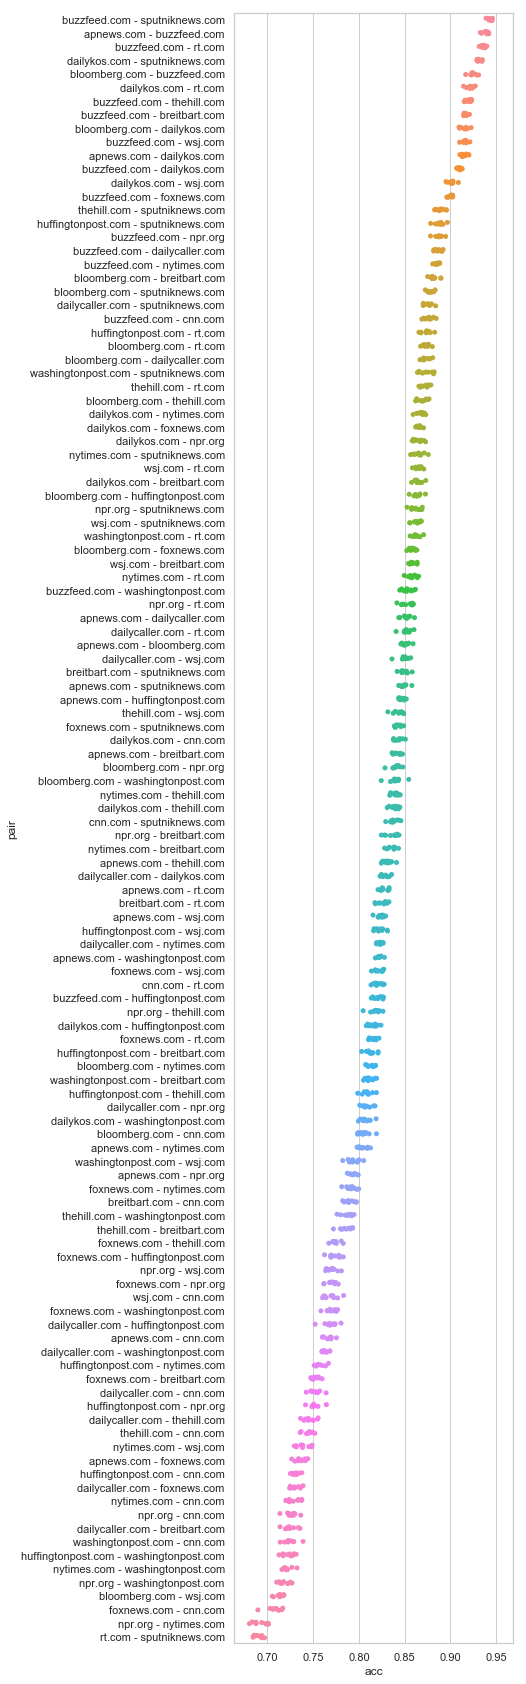

In [85]:
plt.figure(figsize=(5,30))
sns.stripplot(x='acc', y='pair', data=score_df, order=order)